

---



---


# Artificial Intelligence 
## Assignment 3

authors:     
        Lynda Attouche ~ Mattia Arsendi


---



---



## 1. Importing libraries

In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!apt update && apt install python-opengl ffmpeg

In [ ]:
from tqdm.notebook import tqdm

import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

import os
import sys
import random
import pickle

import pandas as pd 
import gym
import gnwrapper

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras import backend as K

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#test: writing rewards in txt file:
path = '/content/drive/My Drive/AI/Project/'

## 2. Setting run type to GPU

To speed up and have an optimal computation time when training the model described in the next section, we use the gpu. 

In [ ]:
config =tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
tf.compat.v1.Session(config=config)
K.set_session
tf.compat.v1.keras.backend.get_session()

### Game - Environment: Alien 

---


We chose to work on the environment described by the Atari game [Alien](https://gym.openai.com/envs/Alien-ram-v0/). It is an arcade game where the player should reach the top of the environment in order to collect a kind of star. But during his path he is chased by aliens. In order to survive, he has to run away from them or face them by shooting fire. On his way there are also alien eggs that he has to destroy. 

This game is available in 2 versions: IMAGE version and RAM one. In our case, we worked with the ram version, where the observations were given by the state of the RAM (an array of 128 bytes).


This game is quite complex with a number of actions of 18: 'noop','fire', 'up', 'right', 'left', 'down', 'right', 'up left', 'down right', 'down left', 'fire up','light right', 'light left', 'light down', 'light right', 'top-left light',' bottom-right light',' bottom-left light'.

### Algorithm
---
At the very beginning, we chose to work with a neural network as a value function approximation and generate the observations by playing the game. However, it turned out that we had difficulties running it on our machines. Looking for solutions to our problem, we found that we could generate data using a neural network. So we ended up making a Deep Q-Network and using experience replay technique. It turns out that by this method we can generate any number of data to train the model. This is not the case when we play by ourselves, we are quite limited by the amount of time we can spend playing. 

To do this, we referred to the following 3 websites:
* [Deep Q Network(DQN)- Applying Neural Network as a functional approximation in Q-learning](https://medium.com/intro-to-artificial-intelligence/deep-q-network-dqn-applying-neural-network-as-a-functional-approximation-in-q-learning-6ffe3b0a9062) 

* [Training A Deep Q-Network - Reinforcement Learning](https://deeplizard.com/learn/video/0bt0SjbS3xc)

* [Replay Memory Explained - Experience For Deep Q-Network Training](https://deeplizard.com/learn/video/Bcuj2fTH4_4#:~:text=A%20key%20reason%20for%20using,therefore%20lead%20to%20inefficient%20learning.)



-- **Deep Q-Network**

 As in the lab, we decided to approximate the value function by a neural network. Indeed, for a given state/observation, the neural network predicts/returns the estimated q-values for each action that can be performed from this state. As mentioned before, this network approaches the q-value function which follows the Bellman equation that we can find in the code. However, we used this concept with a technique called *replay experience*.

-- **Replay experience**

By using this strategy, the agent learns from its previous experiences. For each episode, at each time step of the training, the experience/observation is saved in order to generate data that can be found in the replay memory. From this dataset, a sample of observations is taken to train the neural network.


## 3. Building the Agent 


**Neural Network Architecture**


The neural network used has two fully connected layers with respectively 128 and 32 neurons. (The choice of the number of neurons was retrieved after some tests). 



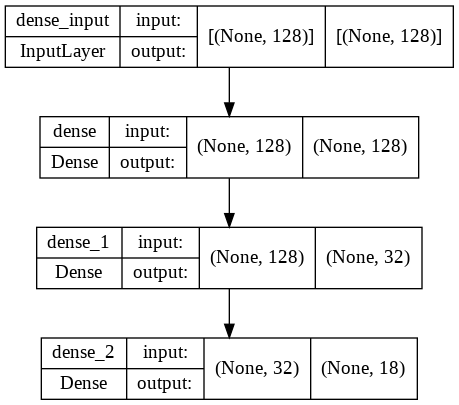


We can see that the output of our neural network is of dimension 18, which corresponds to the number of actions we have. 

In [ ]:
class Agent():
  def __init__(self, env):
    """
    Initializes the Agent class
    @params:
            env : game environment
    @return: 
            setting the environment
    """
    self.env = env #setting the environment

  def model(self,lr):
    """
      Defines the model (ANN), q-value function approximator
      @params:
              lr: learning rate
      @return: 
              compiled neural network
    """
    states_size = env.observation_space.shape
    num_actions = env.action_space.n
    model = Sequential()
    model.add(Dense(128,input_shape=states_size, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics='accuracy')
    #model.summary()
    return model

  def training_model(self, replay_memory, gamma, min_obs, batch_size):
    """
    Trains the q-values function approximator (neural network) for one episode
    @params:
            replay memory (list): observations recorded in memory
            gamma (float): discount factor
            min_obs (int): minimum number of observation required to train the model
            batch_size (int):  number of training examples needed 
    @return: 
            history of the neural network
    """
    #we need to train the model only if we have a certain amount of observation in the memory, so we should define a threshold for that
    #i.e: min_obs will be the threshold, if the replay memory contains less observation than this threshold value, we cannot train the model
    if len(replay_memory) < min_obs: #cannot train 
      return 

    #we have a certain amount of observation in our replay memory
    #we train our model on a random batch from it of size batch size
    batch = random.sample(replay_memory,batch_size)
    m = 1
    #getting states table before the action 
    states_beforeAction = np.array([(observation/255) for (observation, action, reward, new_observation, done) in batch])
    #predicting action value table using the model q(s,a), will be model input 
    q_beforeAction = self.model_.predict(states_beforeAction)

    #getting states table after the action 
    states_afterAction = np.array([(observation/255) for (observation, action, reward, new_observation, done) in batch])
    #predicting action value table of the new obs using the model q'(s',a')
    q_afterAction= self.target_model.predict(states_afterAction)

    #updating the value action table
    for i, (observation, action, reward, new_observation, done) in enumerate(batch):
      if not done: #if we are not in a terminal state
        tmp = reward + gamma*np.max(q_afterAction[action]) #bellman equation 
      else:
        tmp = reward 

      q_beforeAction[i][action] = tmp #updating q-value table

    #training the  neural network 
    history = self.model_.fit(states_beforeAction, q_beforeAction,validation_split = 0.15, verbose=0, shuffle=True)
    return history

  def train(self,nb_episodes,eps,gamma,batch_size,min_obs,lr):
    """
    Trains the q-values function approximator for all  episodes
    @params:
            nb_episodes (int): number of episodes to play
            eps (float): probability of choosing to explore in epsilon greedy algorithm
            gamma (float): discount factor
            min_obs (int): minimum number of observation required to train the model
            batch_size (int):  number of training examples needed 
            lr (float): learing rate
    @return: 
            reward: list of rewards (contains rewards of all episodes)
            model_: approximator
            history: history of the approximator
    """
    #getting approximator network
    self.model_ = self.model(lr)
    #getting target network 
    self.target_model = self.model(lr)
    self.target_model.set_weights(self.model_.get_weights())

    #total rewards, will contain all the rewards of all episodes
    rewards = []

    #init memory
    replay_mem = []

    #time steps
    steps = 0

    #videos of episodes
    videos = []

    #threshold for copying weights to the target network 
    T = 1000 
    #for each episode
    for episode in tqdm(range(nb_episodes)):
      #number of lives at the begining of the episode
      nb_lives = 3
      #starting state
      obs = self.env.reset()
      done = False #not terminate state
      #reward of the current episode
      reward_ep = 0
      #step for episode
      step_ep = 0

      while not done: #while not terminate state
        #Getting action using epsilon greedy
        if  np.random.randn(0, 1) <= eps: #exploration
          #choose random action from the action space we have
          action = self.env.action_space.sample()
        else: #exploitation
          #prediction of the action value 
          q_values = self.model_.predict((obs/255).reshape(1,-1))
          action = np.argmax(q_values) #pick the max
        
        #here we have done one time step obs_t -> obs_t+1 (with action at)
        new_obs,reward,done,info = env.step(action)
        #adding this to the replay memory 
        replay_mem.append([obs,action,reward,new_obs,done])

        #before updating, we need to check if we are still alive
        #so we can update life status
        current_nb_lives = env.ale.lives()
        if current_nb_lives - nb_lives != 0: #3-3=0
          lost = False
        else:
          lose = True

        nb_lives = current_nb_lives #updating number of lives to go

        #updating 
        obs = new_obs
        step_ep +=1 
        steps +=1
        reward_ep +=reward
        # Train main model every number of steps
        if done:
          history = self.training_model(replay_mem,gamma, min_obs, batch_size)
      
      # Update target model's weights every number of steps
      if steps >= T:
        self.target_model.set_weights(self.model_.get_weights())
        steps_to_update_weights = 0
      
      rewards.append(reward_ep)
      #self.env.display()

    # Close the environment 
    self.env.close()
    return rewards,self.model_, history

## 4. Setting hyperparameters

The choice of hyperparameters (except $\gamma$ and the number of episodes) was made after a number of tests where we compared the accuracy obtained each time. 

For the number of episodes, we were constrained and limited by **100**. When we tried to test a higher number, the notebook crashed and the kernel disconnected.
We think that the accuracy would be better than the one we have with a higher number of episodes because in this case we will have more data. 


In [ ]:
nb_episodes= 100 #number of episodes 
eps = 0.1 #epsilon (for epsilon greedy algorithm)
gamma = 0.85 #discount factor
lr = 0.001 #learning rate
batch_size= 256 #number of batches 
min_obs = 50 #minimum number of observation for training 

## 5. Training the agent

In the following cells, we train the neural network with the selected hyperparameters.

We decided that each time a model is trained ($\gamma$ varying), we save it. And every saved model can be found in "Project/models/mymodel"

This choice was made for 3 reasons: to save time when reworking the notebook, we couldn't train different models at once (the notebook would crash because of the memory) and so that you can test it more easily. 
For the same reasons, we have saved the rewards obtained during training. 

In [ ]:
#loading game environment
env = gnwrapper.Monitor(gym.make('Alien-ram-v0'))

In [ ]:
#creating agent
agent = Agent(env)

In [ ]:
#training agent and saving the model 

#rewards,model,history = agent.train(nb_episodes,eps,gamma,batch_size,min_obs,lr)
#agent.model_.save("/content/drive/My Drive/AI/Project/models/model_085")
#np.savetxt(path+'rewards_0.85.txt', rewards, delimiter="\n", fmt="%s")

In [ ]:
def plot_reward(rewards,c,s):
  """
    plots obtained rewards respect to episodes
    @params:
            rewards (list/array): list of rewards
            c (string): color
            s (string): label
    @return:
            plot
  """
  plt.rcParams["figure.figsize"] = (8,5)
  plt.plot(range(len(rewards)),rewards,c,label=s)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.legend()
  plt.title('Rewards/episodes')

## 6. Comparing results for different value of $\gamma$

We tested a number of different values for $\gamma$. To compare them, we used the results obtained during the training and the test. The results are the amount of rewards obtained during the episodes

### 6.1. Analysis of training results

As mentioned above, we have saved the rewards obtained during the training. They will now be used to compare our models as follows

In [ ]:
#loading results from the txt files saved during the training stage
rewards_training_05 = loadtxt(path+'rewards_0.5.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.5
rewards_training_06 = loadtxt(path+'rewards_0.6.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.6
rewards_training_07 = loadtxt(path+'rewards_0.7.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.7
rewards_training_075 = loadtxt(path+'rewards_0.75.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.75
rewards_training_08 = loadtxt(path+'rewards_0.8.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.8
rewards_training_085 = loadtxt(path+'rewards_0.85.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.85
rewards_training_09 = loadtxt(path+'rewards_0.9.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.9
rewards_training_99 = loadtxt(path+'rewards_0.99.txt', comments="#", delimiter=",", unpack=False) #rewards for model with gamma = 0.99

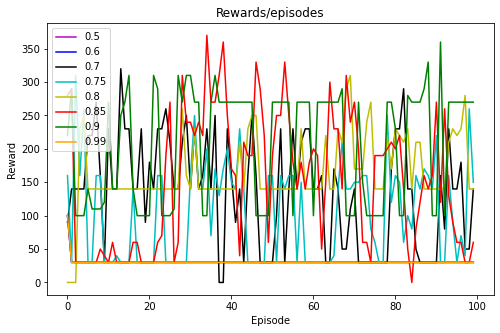

In [ ]:
#plotting the results
rewards_training = [rewards_training_05,rewards_training_06,rewards_training_07,rewards_training_075,rewards_training_08,rewards_training_085,rewards_training_09,rewards_training_99]
colors = ['m','b','k','c','y','r','g','orange']
gammas = ['0.5','0.6','0.7','0.75','0.8','0.85','0.9','0.99']
i = 0
for rewards in rewards_training:
  plot_reward(rewards,colors[i],gammas[i])
  i+=1

We plot each model rewards alone, to clear analysis/view

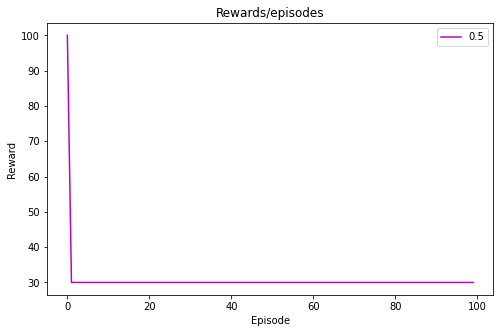

In [ ]:
plot_reward(rewards_training[0],colors[0],gammas[0])

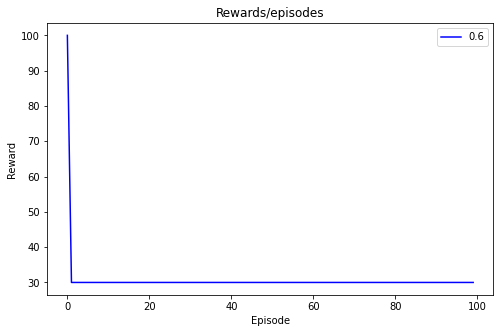

In [ ]:
plot_reward(rewards_training[1],colors[1],gammas[1])

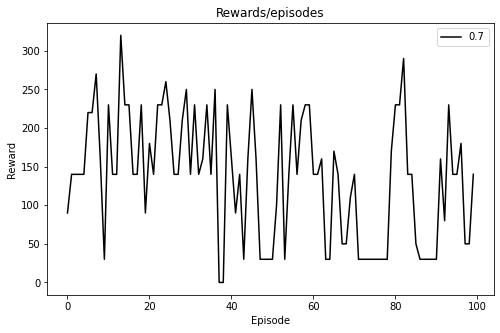

In [ ]:
plot_reward(rewards_training[2],colors[2],gammas[2])

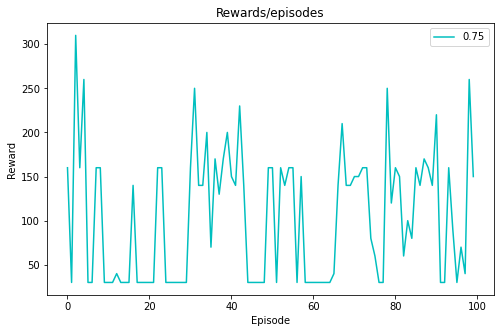

In [ ]:
plot_reward(rewards_training[3],colors[3],gammas[3])

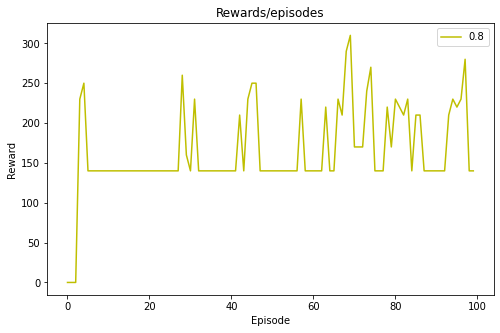

In [ ]:
plot_reward(rewards_training[4],colors[4],gammas[4])

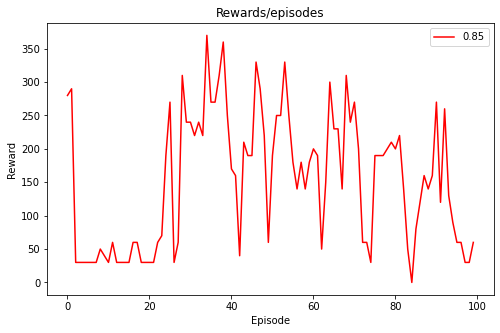

In [ ]:
plot_reward(rewards_training[5],colors[5],gammas[5])

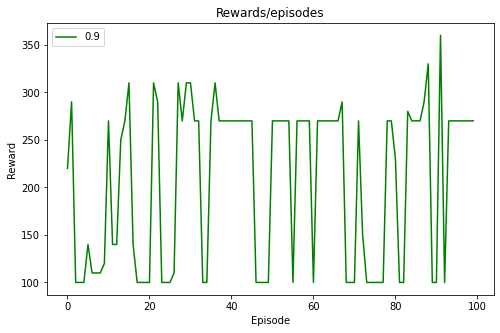

In [ ]:
plot_reward(rewards_training[6],colors[6],gammas[6])

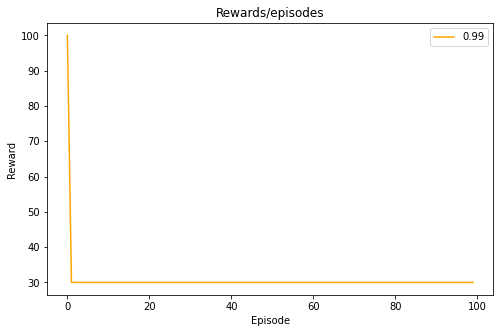

In [ ]:
plot_reward(rewards_training[7],colors[7],gammas[7])

**Comments**
* We notice that for $\gamma$ values below 0.7 and above 0.9, the rewards are very low in contrast to the other results. 

* With $\gamma$ between 0.7 and 0.9, we get quite high rewards oscillations reaching a maximum value of 300-350. This is clearly better.

We can notice from the previous plots a present noise in the curves. To handle this, we compute the average cumulative rewards.

To more understand this, we referred to this article: 
[Reinforcement Learning: Sample-Averages w/ ε-greedy selection](https://medium.com/swlh/reinforcement-learning-foundations-sample-averages-w-%CE%B5-greedy-selection-627f0291cf5)


 This is defined and tested in the following cells:

In [ ]:
def average(rewards):
  """
  Computes the average cumulative rewards
  @params:
          rewards (list/array): rewards 
  @return:
          list of averages
  """
  c = 0
  averages = []
  size = 50
  while c<len(rewards)-size+1: #while we don't reach all rewards
    tmp = rewards[c:c+size]
    av = np.sum(tmp)/size
    averages.append(av)
    c+=1
  return averages

In [ ]:
def plot_avr(averages,c,gamma):
  """
    Plotting cumulative average rewards
    @params:
          averages (list): average cumulative rewards
          c (string): color
          gamma (string): gamma value
    @return 
          plotting
  """
  plt.rcParams["figure.figsize"] = (8,5)
  plt.plot(range(len(averages)), averages,label=gamma,color = c)
  plt.legend()
  plt.xlabel('Episode')
  plt.ylabel('Average reward')

In [ ]:
#computing the cumulative average rewards for each model 
averages_05 = average(rewards_training[0]) #average for the model with gamma = 0.5
averages_06 = average(rewards_training[1]) #average for the model with gamma = 0.6
averages_07 = average(rewards_training[2]) #average for the model with gamma = 0.7
averages_075 = average(rewards_training[3]) #average for the model with gamma = 0.75
averages_08 = average(rewards_training[4]) #average for the model with gamma = 0.8
averages_085 = average(rewards_training[5]) #average for the model with gamma = 0.85
averages_09 = average(rewards_training[6])  #average for the model with gamma = 0.9
averages_099 = average(rewards_training[7]) #average for the model with gamma = 0.99

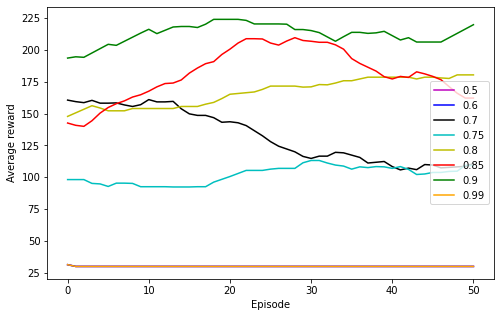

In [ ]:
#list that contains the average cumulative rewards obtained for each model
averages = [averages_05,averages_06,averages_07 ,averages_075 ,averages_08,averages_085,averages_09,averages_099]
i = 0
for average in averages:
  plot_avr(average,colors[i],gammas[i])
  i+=1

Plotting the average rewards for each model

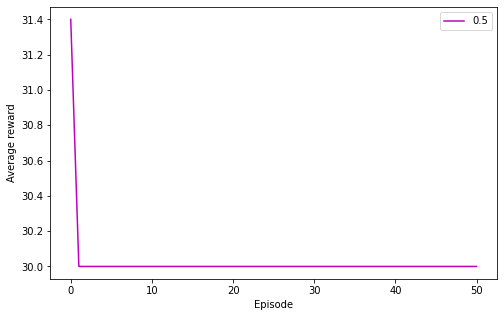

In [ ]:
plot_avr(averages_05,colors[0],gammas[0])

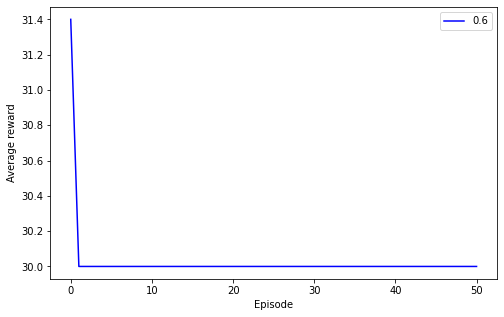

In [ ]:
plot_avr(averages_06,colors[1],gammas[1])

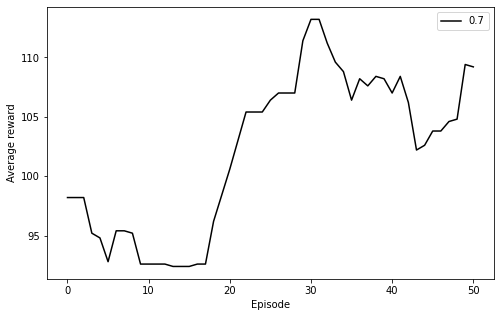

In [ ]:
plot_avr(averages_075,colors[2],gammas[2])

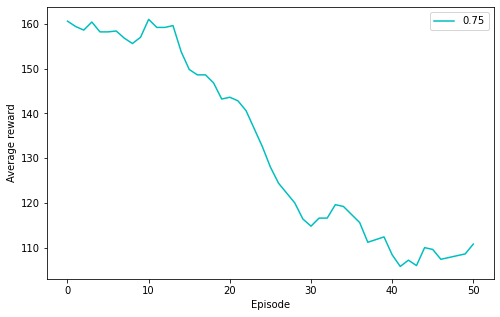

In [ ]:
plot_avr(averages_07,colors[3],gammas[3])

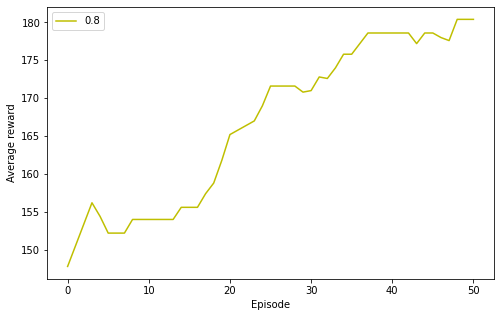

In [ ]:
plot_avr(averages_08,colors[4],gammas[4])

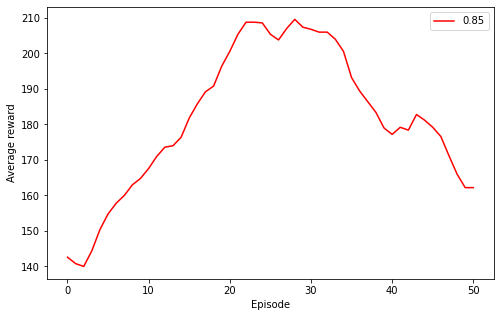

In [ ]:
plot_avr(averages_085,colors[5],gammas[5])

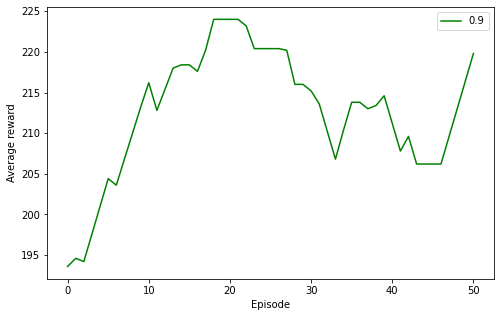

In [ ]:
plot_avr(averages_09,colors[6],gammas[6])

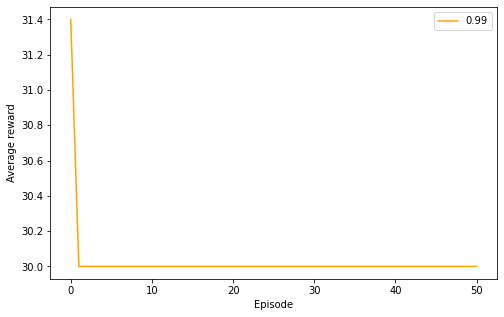

In [ ]:
plot_avr(averages_099,colors[7],gammas[7])

From these different curves with less noise, we can notice that the best value of gamma (the one that gives us highest scores) is 0.9. 

These new plots confirm our previous comment: the values of gamma lower than 0.7 and higher than 0.9 are not giving good results

### 6.2. Analysis of test results

Now for the testing step, we compare the predictions that the neural network makes for each different value of $\gamma$.
The function performing this is described in the next cell.  

In [ ]:
def test(model,env,nb_iters):
  """
  Testing the model 
  @params: 
      model: trained q-value function approximator (ANN) 
      env: game environment
      nb_iters: number of iterations
  """
  rewards = [] #values of rewards for all episodes
  for iter in tqdm(range(nb_iters)):
    #itializing environment
    obs = env.reset()
    done = False #true if the state/observation is terminate state
    ep_reward = 0 #value of rewards for each episode
    while not done:
      q_values = model.predict((obs/255).reshape(1,-1)) #predicting the q_values
      action = np.argmax(q_values) #selecting the action that gave us the best value
      new_obs, reward, done, info = env.step(action) #setting a step in the game
      ep_reward += reward #increasing episodes rewards
      obs = new_obs #updating observation 
    rewards.append(ep_reward) #add episode rewards to the model rewards
  env.close() #closing the environment

  return rewards


In [ ]:
#loading the pretrained models 
path_ = "/content/drive/My Drive/AI/Project/models/"
models = []
for m in os.listdir(path_):
  model = load_model(path_+m)
  models.append((m,model))

In [ ]:
#printing our models: to check if all of them have been added
models

[('model_07', <keras.engine.sequential.Sequential at 0x7fce0ffbf0d0>),
 ('model_08', <keras.engine.sequential.Sequential at 0x7fce00126dd0>),
 ('model_085', <keras.engine.sequential.Sequential at 0x7fcd9335acd0>),
 ('model_099', <keras.engine.sequential.Sequential at 0x7fcd93245f50>),
 ('model_09', <keras.engine.sequential.Sequential at 0x7fcd930bf490>),
 ('model_075', <keras.engine.sequential.Sequential at 0x7fcd93253c90>),
 ('model_05', <keras.engine.sequential.Sequential at 0x7fcd92e06810>),
 ('model_06', <keras.engine.sequential.Sequential at 0x7fcd92b5eb90>)]

Now we have our model, we need to evaluate and select the best value of $\gamma$. 

To do so, we decided to play with our agent during 4 iteration and compare the resulted values. 

This is done in the following cells:

In [ ]:
#testing the models
test_reward_07 = test(models[1][1],env,4) #value of gamma = 0.7
test_reward_075 = test(models[0][1],env,4) #value of gamma = 0.75
test_reward_085 = test(models[3][1],env,4) #value of gamma = 0.85
test_reward_08 = test(models[2][1],env,4) #value of gamma = 0.8
test_reward_09 = test(models[5][1],env,4) #value of gamma = 0.9
test_reward_099 = test(models[4][1],env,4) #value of gamma = 0.99
test_reward_05 = test(models[6][1],env,4) #value of gamma = 0.5
test_reward_06 = test(models[7][1],env,4) #value of gamma = 0.6

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

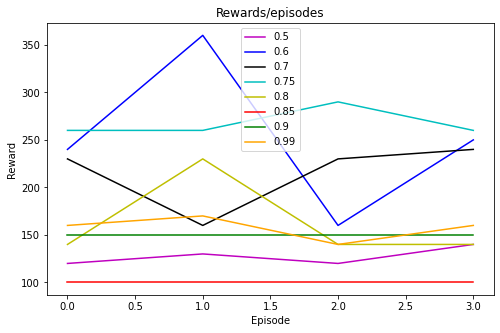

In [ ]:
#list of rewards obtained for each model during the test phase
rewards_test = [test_reward_05,test_reward_06,test_reward_07 ,test_reward_075 ,test_reward_08,test_reward_085,test_reward_09,test_reward_099]
colors = ['m','b','k','c','y','r','g','orange']
gammas = ['0.5','0.6','0.7','0.75','0.8','0.85','0.9','0.99']
i = 0
for rewards in rewards_test:
  plot_reward(rewards,colors[i],gammas[i])
  i+=1

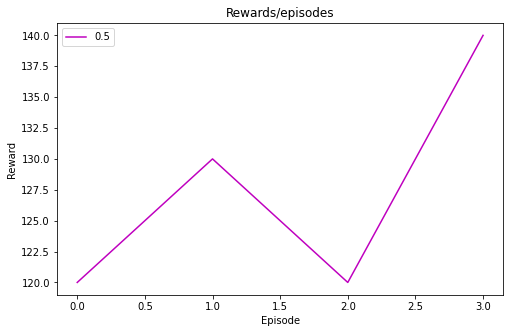

In [ ]:
plot_reward(rewards_test[0],colors[0],gammas[0])

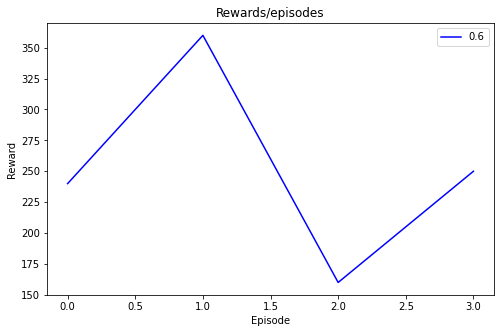

In [ ]:
plot_reward(rewards_test[1],colors[1],gammas[1])

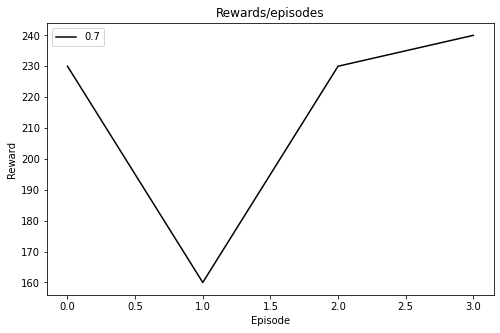

In [ ]:
plot_reward(rewards_test[2],colors[2],gammas[2])

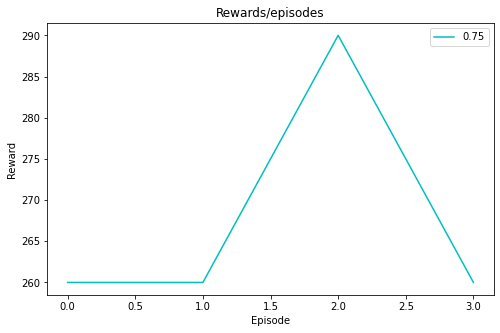

In [ ]:
plot_reward(rewards_test[3],colors[3],gammas[3])

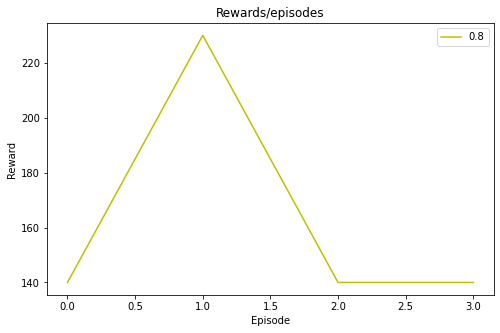

In [ ]:
plot_reward(rewards_test[4],colors[4],gammas[4])

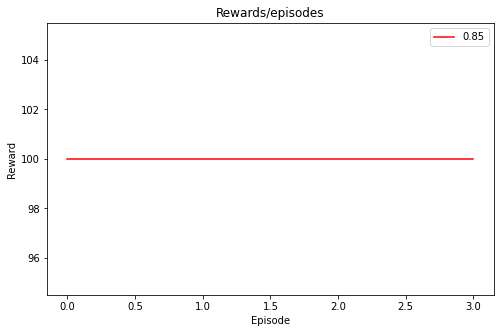

In [ ]:
plot_reward(rewards_test[5],colors[5],gammas[5])

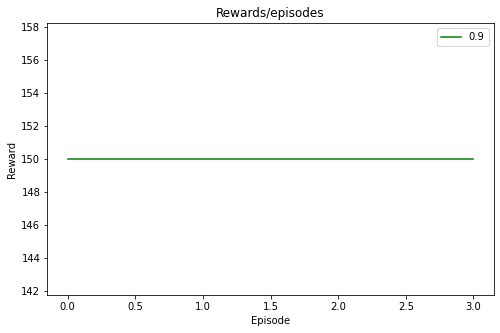

In [ ]:
plot_reward(rewards_test[6],colors[6],gammas[6])

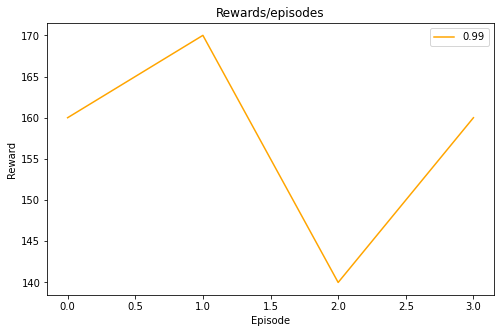

In [ ]:
plot_reward(rewards_test[7],colors[7],gammas[7])

In order to make a clearer analysis and have a more visible comparison, we have calculated the average of the rewards obtained for each model as well as the maximum and minimum. The results are summarised in the following dataframe:

In [ ]:
mean = [np.mean(r) for r in rewards_test] #computing the mean value in each model rewards
max = [np.max(r) for r in rewards_test] #computing the max value in each model rewards
min = [np.min(r) for r in rewards_test] #computing the min value in each model rewards

In [ ]:
#creating a dataframe to have clear results
l = [['model_05',mean[0],max[0],min[0]]
     ,['model_06',mean[1],max[1],min[1]]
     ,['model_07',mean[2],max[2],min[2]]
     ,['model_075',mean[3],max[3],min[3]]
     ,['model_08',mean[4],max[4],min[4]]
     ,['model_085',mean[5],max[5],min[5]]
     ,['model_09',mean[6],max[6],min[6]]
     ,['model_099',mean[7],max[7],min[7]]]

df = pd.DataFrame(l, columns =['Model', 'Mean', 'Max','Min'], dtype = float)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


,Model,Mean,Max,Min
0,model_05,127.5,140.0,120.0
1,model_06,252.5,360.0,160.0
2,model_07,215.0,240.0,160.0
3,model_075,267.5,290.0,260.0
4,model_08,162.5,230.0,140.0
5,model_085,100.0,100.0,100.0
6,model_09,150.0,150.0,150.0
7,model_099,157.5,170.0,140.0


The values of minimum rewards and maximums allow us to situate ourselves a bit. But the most important metric is the average. It allows us to know which $\gamma$ value gives the best performing agent. 

We can see for example that, in spite of the fact that the model with $\gamma = 0.6$ allows us to obtain the maximum value of rewards. Nevertheless, its average is lower than the one of the model with $\gamma = 0.75$ which in fact turns out to be the best. We thus conclude that $\gamma = 0.75$, guarantees us to have the most optimal and powerful agent. 